# Construct The Room Maze Environment

In [1]:
import sys
sys.path.append('../')
from panav.environment.env import DefaultEmtpyEnv
from panav.environment.utils import box_2d_center

from panav.viz import draw_env,draw_hybrid

from shapely import Point

%load_ext autoreload
%autoreload 2

# The Room Maze environment

In [2]:
class Room(DefaultEmtpyEnv):
    def __init__(self, limits=[[-10,10],[-10,10]], N_agent=6):
        super().__init__(limits, N_agent)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


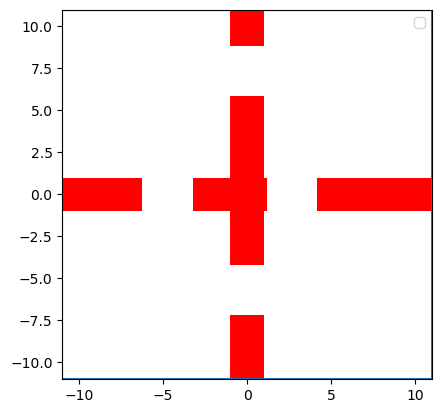

In [3]:
import numpy as np
import networkx as nx

from panav.tunnels import Tunnel

def horizontal_multi_tunnel_wall(x_min,x_max,gap_x_locs,tunnel_width,wall_thickness=5, wall_y_offset=0):
        d = wall_thickness # Thickness of the wall

        l = x_min
            
        obstacles = []

        for i in range(len(gap_x_locs)+1):
          
            if i == len(gap_x_locs):
                r = x_max
            else:
                r = gap_x_locs[i] - tunnel_width/2

            
            side = np.array([r-l, d])
            center = np.array([(l + r)/2, wall_y_offset])
            # print(side,center,l,r)
            obstacles.append(box_2d_center(center,side))
            
            l = r + tunnel_width

        return obstacles

def vertical_multi_tunnel_wall(y_min,y_max,gap_y_locs,tunnel_width,wall_thickness=5, wall_x_offset=0):
        d = wall_thickness # Thickness of the wall

        bottom = y_min
            
        obstacles = []

        for i in range(len(gap_y_locs)+1):
          
            if i == len(gap_y_locs):
                top = y_max
            else:
                top = gap_y_locs[i] - tunnel_width/2

            
            side = np.array([d,top-bottom])
            center = np.array([wall_x_offset,(top + bottom)/2])
            # print(side,center,l,r)
            obstacles.append(box_2d_center(center,side))
            
            bottom = top + tunnel_width

        return obstacles

def random_remove_edge(G_in,drop_rate=0.2,max_iter = 50): 
    for _ in range(max_iter):
        G = nx.Graph(G_in)
        n = G.number_of_edges()
        es = [e for e in G.edges]
        to_remove = np.random.choice(np.arange(len(es)),int(n * drop_rate),replace=False)

        for i in to_remove:
            G.remove_edge(*es[i])

        if nx.is_connected(G):
            return G
    return G_in

bloating_r = 0.5
vmax = 1.0

limits = [(-20,20),(-20,20)] 
N = 0

n_col = 2
n_row = 2
cell_width = 10.0
cell_height = 10.0
wall_thickness = 2.0

total_width = n_col * (cell_width + wall_thickness) - wall_thickness
total_height = n_row * (cell_height + wall_thickness) - wall_thickness

limits = [(-total_width/2,total_width/2),(-total_height/2,total_height/2)]
env = Room(limits = limits, N_agent = N)


np.random.seed(7)
G = nx.grid_2d_graph(n_col,n_row)
G = random_remove_edge(G,drop_rate=0.1)

gap_width = bloating_r * 6

pos = {}
origin =  - np.array([total_width,total_height])/2
for i,j in G.nodes:
    pos[(i,j)] = np.array([cell_height/2 + j * (cell_height+wall_thickness),cell_width/2 + i * (cell_width + wall_thickness) ]) + origin


col_tunnels = []
# Add horizontal tunnels
for i in range(n_row-1):
    # Add horizontal tunnels at the ith row
    y = cell_height + wall_thickness/2 +  i * (cell_height+wall_thickness) +  origin[1]

    gap_x_locs = []
    for j in range(n_col):
        e = ((i,j),(i+1,j))
        if e in G.edges:
            alpha = np.random.rand() # alpha can be randomly chosen later to be any number between 0 and 1. The random seed is fixed, though, so the graph layout won't change even if the algorithm is called multiple times.
            gap_x = j * (cell_width+wall_thickness) + gap_width/2 * alpha + (cell_width-gap_width/2)*(1-alpha) + origin[0]
            gap_x_locs.append(gap_x)

            f1_l = np.array([gap_x - gap_width/2, y - wall_thickness/2])
            f1_r = f1_l + np.array([gap_width,0])
            f1 = [f1_l,f1_r]
            
            f2_l = f1_l + np.array([0,wall_thickness])
            f2_r = f1_r + np.array([0,wall_thickness])
            f2 = [f2_l,f2_r]

            n1 = f2_l - f1_l
            n2 = -n1
            col_tunnels.append(Tunnel(f1,n1,f2,n2,end_point_buffer=0.2))

    env.obstacles += horizontal_multi_tunnel_wall(*env.limits[0],gap_x_locs,gap_width,wall_thickness,y)

row_tunnels = []
# Add vertical tunnels
for j in range(n_col-1):
    # Add vertical tunnels at the ith row
    x = cell_width + wall_thickness/2 +  j * (cell_width+wall_thickness) +  origin[1]

    gap_y_locs = []
    for i in range(n_row):
        e = ((i,j),(i,j+1))
        if e in G.edges:
            # alpha can be randomly chosen later to be any number between 0 and 1. The random seed is fixed, though, so the graph layout won't change even if the algorithm is called multiple times.
            alpha = np.random.rand()
            gap_y = i * (cell_height+wall_thickness) + gap_width/2 * alpha + (cell_height-gap_width/2)*(1-alpha) + origin[1]
            gap_y_locs.append(gap_y)

            f1_lo = np.array([x - wall_thickness/2, gap_y - gap_width/2])
            f1_hi = f1_lo + np.array([0,gap_width])
            f1 = [f1_lo,f1_hi]
            
            f2_lo = f1_lo + np.array([wall_thickness,0])
            f2_hi = f1_hi + np.array([wall_thickness,0])
            f2 = [f2_lo,f2_hi]

            n1 = f2_lo - f1_lo
            n2 = -n1
            row_tunnels.append(Tunnel(f1,n1,f2,n2,end_point_buffer=0.2))

    env.obstacles += vertical_multi_tunnel_wall(*env.limits[1],gap_y_locs,gap_width,wall_thickness,x)

# nx.draw_networkx(G,pos)
draw_env(env,obs_alpha=1.0)


In [4]:

def point_feasible(HG, test_pt,dist_2_tunnel,dist_2_obs,dist_2_neighbor):
    '''
        Determine if the test_pt is free from any obstacle or tunnels
    '''
    x_limits = HG.env.limits[0]
    y_limits = HG.env.limits[1]
    if any([abs(test_pt[0]-x_limits[0]) < dist_2_obs,
            abs(test_pt[0]-x_limits[1]) < dist_2_obs,
            abs(test_pt[1]-y_limits[0]) < dist_2_obs,
            abs(test_pt[1]-y_limits[1]) < dist_2_obs,
    ]):
        return False
             

    pt = Point(test_pt)
    for obs in HG.env.obstacles:
        if obs.verts.distance(pt) < dist_2_obs:
            return False
            

    for tun in HG.tunnels:
        if tun.region.distance(pt) < dist_2_tunnel:
            return False
        
    for s in HG.env.starts + HG.env.goals:
        if np.linalg.norm(s-test_pt)<dist_2_neighbor:
            return False
    return True

def random_feasible_point(HG,dist_2_tunnel,dist_2_obs,dist_2_neighbor,max_iter = 500):
    total_height = HG.env.limits[1][1] - HG.env.limits[1][0]
    total_height = HG.env.limits[0][1] - HG.env.limits[0][0]
    for _ in range(max_iter):
        test_pt = np.random.rand(2) * np.array([total_width,total_height]) - np.array([total_width,total_height])/2
        if point_feasible(HG,test_pt,dist_2_tunnel,dist_2_obs,dist_2_neighbor):
            return test_pt
        
    return None



In [5]:
dist_2_obs = 4 * bloating_r

dist_2_tunnel = 6 * bloating_r

dist_2_neighbor = 4 * bloating_r

start_goal_dist = 20 * bloating_r


In [6]:
from matplotlib import pyplot as plt


def random_start_goal(HG,dist_2_tunnel,dist_2_obs,dist_2_neighbor,start_goal_dist):
    max_iter = 500

    candidate_start = random_feasible_point(HG,dist_2_tunnel,dist_2_obs,dist_2_neighbor)

    

    for _ in range(max_iter):
        candidate_goal = random_feasible_point(HG,dist_2_tunnel,dist_2_obs,dist_2_neighbor)
        if np.linalg.norm(candidate_start-candidate_goal)>start_goal_dist:
            return candidate_start,candidate_goal
    return None


from panav.hybrid import HybridGraph

HG = HybridGraph(env,agent_radius=bloating_r,tunnels=col_tunnels+row_tunnels,construct_graph=False)

N_agents = 10
HG.env.starts = []
HG.env.goals = []
for _ in range(N_agents):
    start,goal = random_start_goal(HG,dist_2_tunnel,dist_2_obs,dist_2_neighbor,start_goal_dist)
    HG.env.starts.append(start)
    HG.env.goals.append(goal)

HG.env.calc_start_goal_regions()

HG.__construct_hybrid_graph__()
# plt.scatter(s[:,0],s[:,1],label='start',marker='x')
# plt.scatter(g[:,0],g[:,1],label='goal',marker='*')




/Users/tianpengzhang/opt/miniconda3/envs/PA-NAV/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/tianpengzhang/opt/miniconda3/envs/PA-NAV/lib/python3.11/site-packages/shapely/measurement.py:74: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


optimal


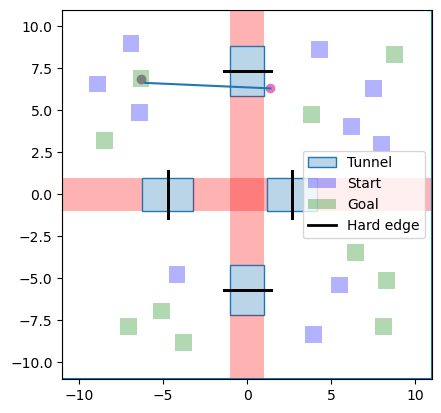

In [33]:

draw_hybrid(HG,display_node=False)
cur_loc = [1.38117, 6.31436]

wp = [-6.31579,  6.89252]
plt.scatter(*cur_loc)
plt.scatter(*wp)

from panav.multi_path import shortest_path
x,_ = shortest_path(env,cur_loc,wp,bloating_r=0.45)

plt.plot(x[0,:],x[1,:])

In [29]:
x

array([[ 1.38117, -0.61194, -3.05334, -6.31579],
       [ 6.31436,  6.46436,  6.64744,  6.89252]])

In [45]:
from panav.PIBT import PIBT_plan

for e in HG.edges:
    if HG.edges[e]['type'] == 'hard':
        HG.edges[e]['occupants'] = set()
        w,v = e
        HG.nodes[v]['occupant'] = HG.nodes[w]['occupant'] = None
      
plans = PIBT_plan(HG,vmax,bloating_r,TIMEOUT=100,debug = False,simple_plan=False)
# plans = TAHP(HG,vmax,bloating_r, TIMEOUT=100)

################# Time step 0 ################
################# Time step 1 ################
################# Time step 2 ################
################# Time step 3 ################
################# Time step 4 ################
################# Time step 5 ################
################# Time step 6 ################
################# Time step 7 ################
################# Time step 8 ################
################# Time step 9 ################
################# Time step 10 ################
################# Time step 11 ################
################# Time step 12 ################
################# Time step 13 ################
################# Time step 14 ################
################# Time step 15 ################
################# Time step 16 ################
################# Time step 17 ################
################# Time step 18 ################
################# Time step 19 ################
################# Time step 20 ################
##

/Users/tianpengzhang/opt/miniconda3/envs/PA-NAV/lib/python3.11/site-packages/shapely/measurement.py:74: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


optimal
################# Time step 51 ################
Planning using MILP
[-0.68173  6.61811] [2.65244 1.4    ]
optimal
################# Time step 52 ################
Planning using MILP
[-0.92336  6.52843] [2.65244 1.4    ]
optimal
################# Time step 53 ################
Planning using MILP
[-1.14909  6.47462] [2.65244 1.4    ]
optimal
################# Time step 54 ################
Planning using MILP
[-0.7661   6.52483] [2.65244 1.4    ]
optimal
################# Time step 55 ################
Planning using MILP
[-0.99304  6.47246] [2.65244 1.4    ]
optimal
################# Time step 56 ################
Planning using MILP
[-0.59357  6.45187] [2.65244 1.4    ]
optimal
################# Time step 57 ################
Planning using MILP
[-0.1941   6.43127] [2.65244 1.4    ]
optimal
################# Time step 58 ################
Planning using MILP
[0.20536 6.41067] [2.65244 1.4    ]
optimal
################# Time step 59 ################
Planning using MILP
[0.60483 6.390

In [46]:
from matplotlib import pyplot as plt
from panav.viz import animation
from IPython.display import HTML, display
from matplotlib import rcParams

exec_tau = 1.0

rcParams['animation.embed_limit'] = 2**128
dt = exec_tau 
agents = range(len(plans))
pos_to_ani = [np.array(plans[a][1]) for a in agents]
anim = animation(env, pos_to_ani, bloating_r, dt = dt)
display(HTML(anim.to_jshtml()))
plt.close() 